# Задача:
### Проанализировать, какие факторы сильнее всего влияют на отток клиентов (Exited), и построить интерпретируемую модель.

# Библиотеки
---

In [1]:
import shutil
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import kagglehub
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score,ConfusionMatrixDisplay,precision_score, recall_score, f1_score, roc_auc_score,roc_curve
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import optuna
import shap


import warnings
warnings.filterwarnings("ignore")

In [2]:
random_seed=42

# Грузим датасет
---

In [3]:
# Download latest version
path = kagglehub.dataset_download("shantanudhakadd/bank-customer-churn-prediction")

target_dir = "dataset"

os.makedirs(target_dir,exist_ok=True)

for file in os.listdir(path):
    shutil.move(os.path.join(path,file),os.path.join(target_dir,file))

# Анализируем
---

In [4]:
data = pd.read_csv("dataset\\Churn_Modelling.csv")
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [5]:
desc_data = pd.DataFrame(index = list(data))
desc_data["type"] = data.dtypes
desc_data["amount"] = data.count()
desc_data["num_unique"] = [len(data[column].unique()) for column in data.columns]
desc_data["num_null"] = data.isnull().sum()
desc_data['min'] = data.min()
desc_data['max'] = data.max()
desc_data


,type,amount,num_unique,num_null,min,max
RowNumber,int64,10000,10000,0,1,10000
CustomerId,int64,10000,10000,0,15565701,15815690
Surname,object,10000,2932,0,Abazu,Zuyeva
CreditScore,int64,10000,460,0,350,850
Geography,object,10000,3,0,France,Spain
Gender,object,10000,2,0,Female,Male
Age,int64,10000,70,0,18,92
Tenure,int64,10000,11,0,0,10
Balance,float64,10000,6382,0,0.0,250898.09
NumOfProducts,int64,10000,4,0,1,4


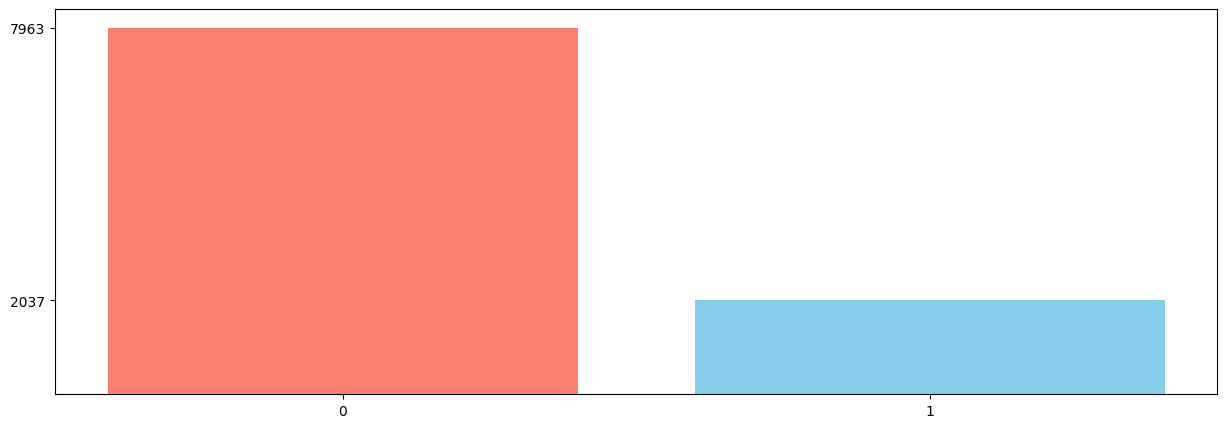

Процентное соотношение Exited: 20.37%
Процентное соотношение NotExited: 79.63%


In [6]:
plt.figure(figsize=(15,5))

exited_count = data["Exited"].value_counts()
plt.bar(exited_count.index,exited_count.values,color = ["salmon","skyblue"])
plt.xticks(exited_count.index)
plt.yticks(exited_count.values)

plt.show()

print(f"Процентное соотношение Exited: {(exited_count[1]/exited_count.sum() * 100):.2f}%")
print(f"Процентное соотношение NotExited: {(exited_count[0]/exited_count.sum() * 100):.2f}%")

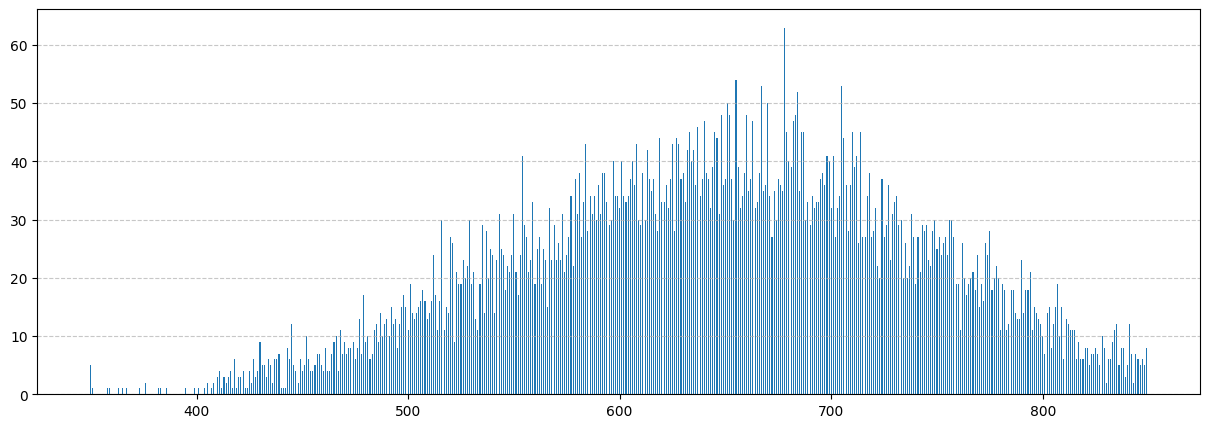

CreditScore
350      5
351      1
358      1
359      1
363      1
      ... 
846      5
847      6
848      5
849      8
850    233
Name: count, Length: 460, dtype: int64


In [7]:
#убираем последний элемент, тк он делает график нечитабельным из-за своего кол-во(233)
creditscore_count = data["CreditScore"].value_counts().sort_index()
score_to_bar = creditscore_count[:-1]

plt.figure(figsize=(15,5))

plt.bar(score_to_bar.index,score_to_bar.values,width=0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

print(creditscore_count)

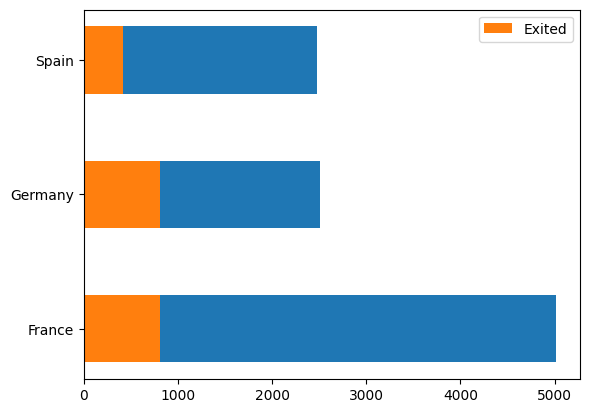

Всего France: 5014
Всего Exited_France: 810
Соотношение France к общему кол-во клиентов: 50.14%
Отношение Exited_France к общему кол-во Exited в France : 16.15%
        
Всего Germany: 2509
Всего Exited_Germany: 814
Соотношение Germany к общему кол-во клиентов: 25.09%
Отношение Exited_Germany к общему кол-во Exited в Germany : 32.44%
        
Всего Spain: 2477
Всего Exited_Spain: 413
Соотношение Spain к общему кол-во клиентов: 24.77%
Отношение Exited_Spain к общему кол-во Exited в Spain : 16.67%
        


In [8]:
geography_count = data["Geography"].value_counts().sort_index()
exited_by_country = data[data["Exited"]==1]["Geography"].value_counts().sort_index()
#print(geography_count,exited_by_country)

fig,ax = plt.subplots()

bar1 = ax.barh(geography_count.index,geography_count.values,height=0.5)
bar2 = ax.barh(exited_by_country.index,exited_by_country.values,height=0.5,label = 'Exited')

plt.legend()
plt.show()

for i in range(len(geography_count.index)):
    print(f"""Всего {geography_count.index[i]}: {geography_count[i]}
Всего Exited_{geography_count.index[i]}: {exited_by_country[i]}
Соотношение {geography_count.index[i]} к общему кол-во клиентов: {(geography_count[i]/geography_count.sum() * 100):.2f}%
Отношение Exited_{geography_count.index[i]} к общему кол-во Exited в {geography_count.index[i]} : {(exited_by_country[i]/geography_count[i] * 100):.2f}%
        """)


Gender
Female    4543
Male      5457
Name: count, dtype: int64 Gender
Female    1139
Male       898
Name: count, dtype: int64


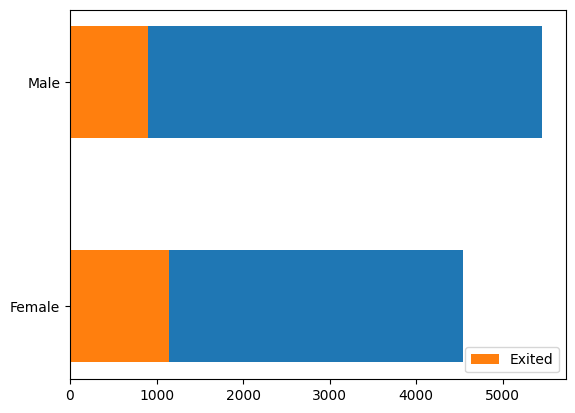

Всего Female: 4543
Всего Exited_Female: 1139
Соотношение Female к общему кол-во клиентов: 45.43%
Отношение Exited_Female к общему кол-во Exited среди Female: 25.07%
        
Всего Male: 5457
Всего Exited_Male: 898
Соотношение Male к общему кол-во клиентов: 54.57%
Отношение Exited_Male к общему кол-во Exited среди Male: 16.46%
        


In [9]:
gender_count = data["Gender"].value_counts().sort_index()
exited_by_gender = data[data["Exited"]==1]["Gender"].value_counts().sort_index()
print(gender_count,exited_by_gender)

fig,ax = plt.subplots()

bar1 = ax.barh(gender_count.index,gender_count.values,height=0.5)
bar2 = ax.barh(exited_by_gender.index,exited_by_gender.values,height=0.5,label = 'Exited')

plt.legend()
plt.show()

for i in range(len(gender_count.index)):
    print(f"""Всего {gender_count.index[i]}: {gender_count[i]}
Всего Exited_{gender_count.index[i]}: {exited_by_gender[i]}
Соотношение {gender_count.index[i]} к общему кол-во клиентов: {(gender_count[i]/gender_count.sum() * 100):.2f}%
Отношение Exited_{gender_count.index[i]} к общему кол-во Exited среди {gender_count.index[i]}: {(exited_by_gender[i]/gender_count[i] * 100):.2f}%
        """)


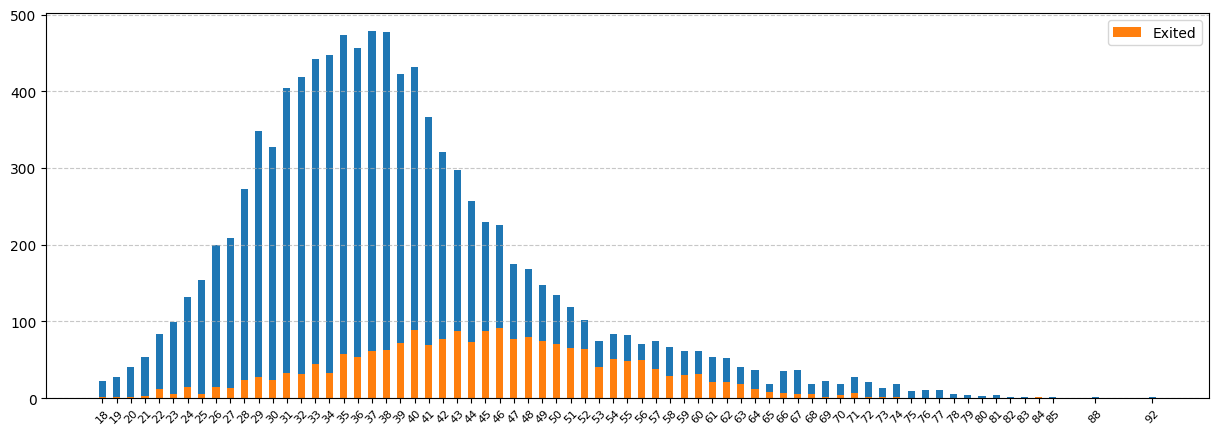

Age
84    1
19    1
73    1
72    1
74    1
69    2
18    2
20    2
21    3
70    4
Name: count, dtype: int64 Age
39    72
44    73
49    75
47    77
42    77
48    80
45    87
43    88
40    89
46    91
Name: count, dtype: int64


In [10]:
age_counts = data['Age'].value_counts().sort_index()
exited_by_age = data[data["Exited"]==1]["Age"].value_counts().sort_index()


fig,ax = plt.subplots(figsize=(15, 5))

bar1 = ax.bar(age_counts.index,age_counts.values,width=0.5)
bar2 = ax.bar(exited_by_age.index,exited_by_age.values,width=0.5,label = 'Exited')

plt.xticks(age_counts.index,rotation=45,fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend()
plt.show()

exited_by_age_first_three = exited_by_age.sort_values()[:10]
exited_by_age_last_three = exited_by_age.sort_values()[-10:]
print(exited_by_age_first_three,exited_by_age_last_three)
#можем заметить, что больше всего уходят люди в возрасте 40-50 лет

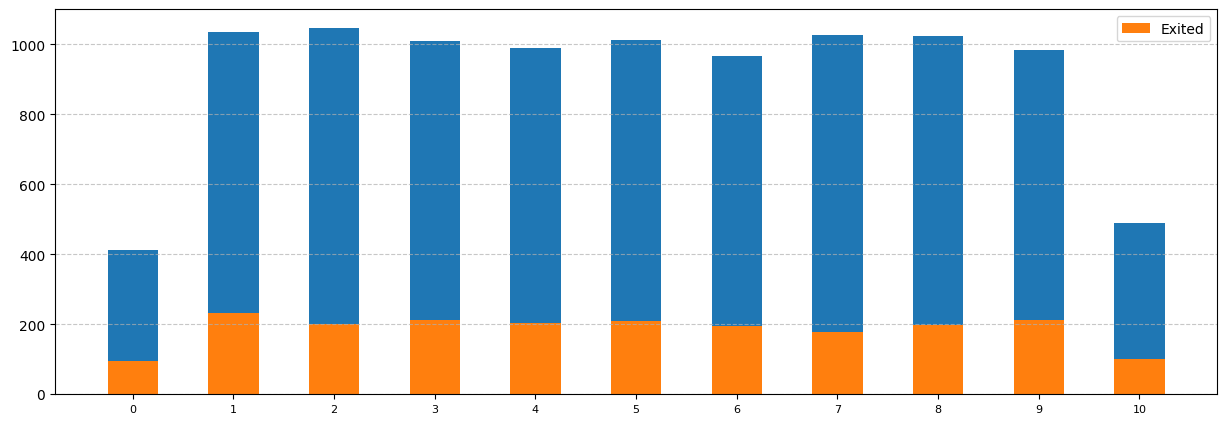

,Tenure,Всего клиентов,Всего Exited,Процент от общего числа клиентов,Процент Exited среди этих
0,0,413,95,4.13,23.00
1,1,1035,232,10.35,22.42
2,2,1048,201,10.48,19.18
3,3,1009,213,10.09,21.11
4,4,989,203,9.89,20.53
5,5,1012,209,10.12,20.65
6,6,967,196,9.67,20.27
7,7,1028,177,10.28,17.22
8,8,1025,197,10.25,19.22
9,9,984,213,9.84,21.65


In [11]:
#Tenure - From how many years customer is in bank

tenure_counts = data['Tenure'].value_counts().sort_index()
exited_by_tenure = data[data["Exited"]==1]["Tenure"].value_counts().sort_index()

fig,ax = plt.subplots(figsize=(15, 5))

bar1 = ax.bar(tenure_counts.index,tenure_counts.values,width=0.5)
bar2 = ax.bar(exited_by_tenure.index,exited_by_tenure.values,width=0.5,label = 'Exited')

plt.xticks(tenure_counts.index,fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend()
plt.show()

tenure_data = []

for i in range(len(tenure_counts.index)):
    tenure = tenure_counts.index[i]
    total = tenure_counts[i]
    exited = exited_by_tenure[i]
    total_percent = ((tenure_counts[i] / tenure_counts.sum()) * 100).round(2)
    exited_percent = ((exited_by_tenure[i] / tenure_counts[i]) * 100).round(2)
    
    tenure_data.append({
        'Tenure': tenure,
        'Всего клиентов': total,
        'Всего Exited': exited,
        'Процент от общего числа клиентов': total_percent,
        'Процент Exited среди этих': exited_percent
    })

df = pd.DataFrame(tenure_data)
df

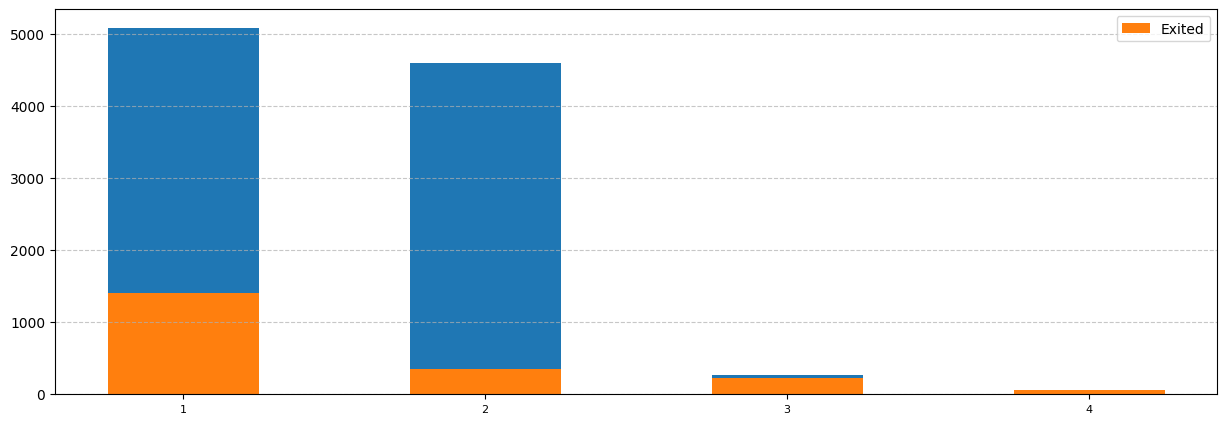

Всего 1: 5084
Всего Exited_1: 1409
Соотношение 1 к общему кол-во клиентов: 50.84%
Отношение Exited_1 к общему кол-во Exited среди 1: 27.71%
        
Всего 2: 4590
Всего Exited_2: 348
Соотношение 2 к общему кол-во клиентов: 45.90%
Отношение Exited_2 к общему кол-во Exited среди 2: 7.58%
        
Всего 3: 266
Всего Exited_3: 220
Соотношение 3 к общему кол-во клиентов: 2.66%
Отношение Exited_3 к общему кол-во Exited среди 3: 82.71%
        
Всего 4: 60
Всего Exited_4: 60
Соотношение 4 к общему кол-во клиентов: 0.60%
Отношение Exited_4 к общему кол-во Exited среди 4: 100.00%
        


In [13]:
numproducts_counts = data['NumOfProducts'].value_counts().sort_index()
exited_by_numproducts = data[data["Exited"]==1]["NumOfProducts"].value_counts().sort_index()

fig,ax = plt.subplots(figsize=(15, 5))

bar1 = ax.bar(numproducts_counts.index,numproducts_counts.values,width=0.5)
bar2 = ax.bar(exited_by_numproducts.index,exited_by_numproducts.values,width=0.5,label = 'Exited')

plt.xticks(numproducts_counts.index,fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend()
plt.show()

for i in range(len(numproducts_counts.index)):
    print(f"""Всего {numproducts_counts.index[i]}: {numproducts_counts.iloc[i]}
Всего Exited_{numproducts_counts.index[i]}: {exited_by_numproducts.iloc[i]}
Соотношение {numproducts_counts.index[i]} к общему кол-во клиентов: {(numproducts_counts.iloc[i]/numproducts_counts.sum() * 100):.2f}%
Отношение Exited_{numproducts_counts.index[i]} к общему кол-во Exited среди {numproducts_counts.index[i]}: {(exited_by_numproducts.iloc[i]/numproducts_counts.iloc[i] * 100):.2f}%
        """)


In [14]:
four_products = data[data['NumOfProducts']==4]
desc_data_four_products = pd.DataFrame(index = list(data))
desc_data_four_products['min'] = four_products.min()
desc_data_four_products['max'] = four_products.max()
desc_data_four_products['mean'] = four_products.drop(columns=["Surname",'Geography',"Gender"]).mean()
desc_data_four_products

#интересно, что все кто имел 4 продукта в банке, ушли 🤔

,min,max,mean
RowNumber,8,9566,5.175183e+03
CustomerId,15568006,15815316,1.567663e+07
Surname,Allan,Yen,NaN
CreditScore,376,850,6.535833e+02
Geography,France,Spain,NaN
Gender,Female,Male,NaN
Age,29,68,4.568333e+01
Tenure,1,10,5.300000e+00
Balance,0.0,195238.29,9.373314e+04
NumOfProducts,4,4,4.000000e+00


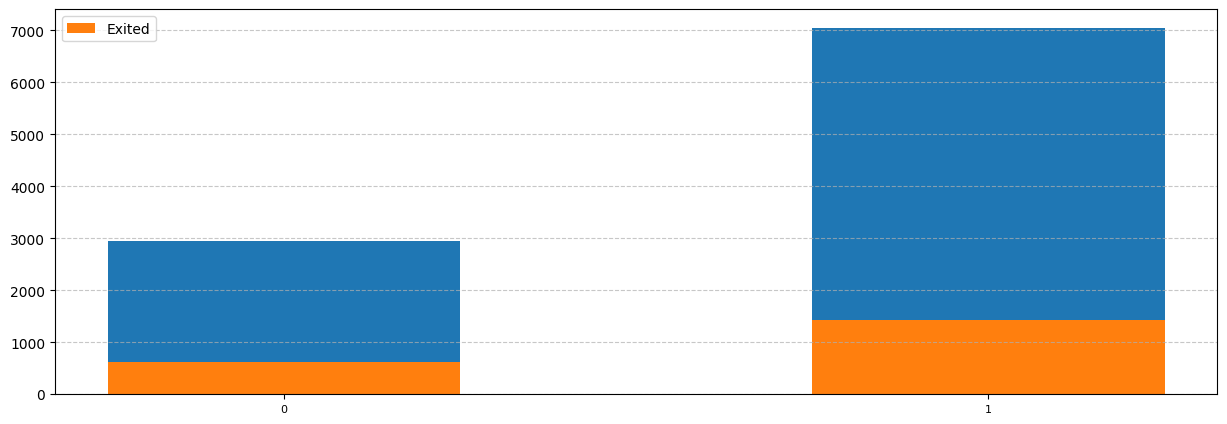

Всего 0: 2945
Всего Exited_0: 613
Соотношение 0 к общему кол-во клиентов: 29.45%
Отношение Exited_0 к общему кол-во Exited среди 0: 20.81%
        
Всего 1: 7055
Всего Exited_1: 1424
Соотношение 1 к общему кол-во клиентов: 70.55%
Отношение Exited_1 к общему кол-во Exited среди 1: 20.18%
        


In [15]:
crcard_counts = data['HasCrCard'].value_counts().sort_index()
exited_by_crcard = data[data["Exited"]==1]["HasCrCard"].value_counts().sort_index()

fig,ax = plt.subplots(figsize=(15, 5))

bar1 = ax.bar(crcard_counts.index,crcard_counts.values,width=0.5)
bar2 = ax.bar(exited_by_crcard.index,exited_by_crcard.values,width=0.5,label = 'Exited')

plt.xticks(crcard_counts.index,fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend()
plt.show()

for i in range(len(crcard_counts.index)):
    print(f"""Всего {crcard_counts.index[i]}: {crcard_counts.iloc[i]}
Всего Exited_{crcard_counts.index[i]}: {exited_by_crcard.iloc[i]}
Соотношение {crcard_counts.index[i]} к общему кол-во клиентов: {(crcard_counts.iloc[i]/crcard_counts.sum() * 100):.2f}%
Отношение Exited_{crcard_counts.index[i]} к общему кол-во Exited среди {crcard_counts.index[i]}: {(exited_by_crcard.iloc[i]/crcard_counts.iloc[i] * 100):.2f}%
        """)

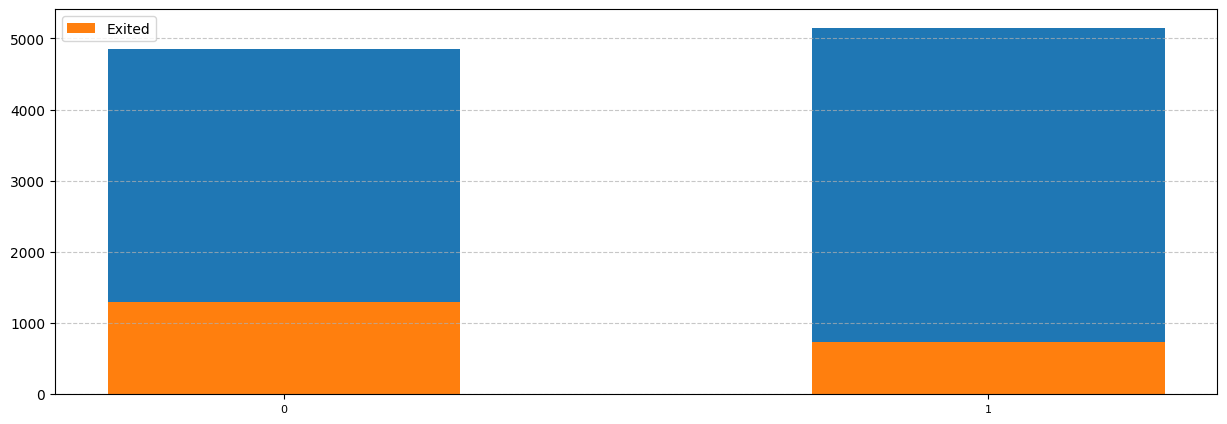

Всего 0: 4849
Всего Exited_0: 1302
Соотношение 0 к общему кол-во клиентов: 48.49%
Отношение Exited_0 к общему кол-во Exited среди 0: 26.85%
        
Всего 1: 5151
Всего Exited_1: 735
Соотношение 1 к общему кол-во клиентов: 51.51%
Отношение Exited_1 к общему кол-во Exited среди 1: 14.27%
        


In [16]:
active_counts = data['IsActiveMember'].value_counts().sort_index()
exited_by_active = data[data["Exited"]==1]["IsActiveMember"].value_counts().sort_index()

fig,ax = plt.subplots(figsize=(15, 5))

bar1 = ax.bar(active_counts.index,active_counts.values,width=0.5)
bar2 = ax.bar(exited_by_active.index,exited_by_active.values,width=0.5,label = 'Exited')

plt.xticks(active_counts.index,fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend()
plt.show()

for i in range(len(active_counts.index)):
    print(f"""Всего {active_counts.index[i]}: {active_counts.iloc[i]}
Всего Exited_{active_counts.index[i]}: {exited_by_active.iloc[i]}
Соотношение {active_counts.index[i]} к общему кол-во клиентов: {(active_counts.iloc[i]/active_counts.sum() * 100):.2f}%
Отношение Exited_{active_counts.index[i]} к общему кол-во Exited среди {active_counts.index[i]}: {(exited_by_active.iloc[i]/active_counts.iloc[i] * 100):.2f}%
        """)

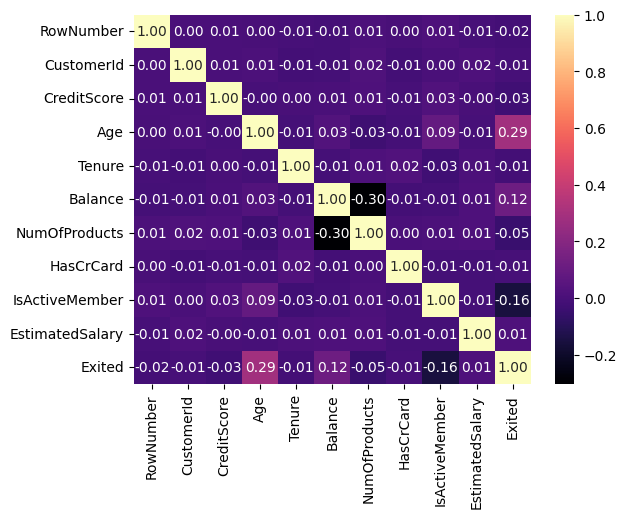

                 RowNumber  CustomerId  CreditScore       Age    Tenure  \
RowNumber         1.000000    0.004202     0.005840  0.000783 -0.006495   
CustomerId        0.004202    1.000000     0.005308  0.009497 -0.014883   
CreditScore       0.005840    0.005308     1.000000 -0.003965  0.000842   
Age               0.000783    0.009497    -0.003965  1.000000 -0.009997   
Tenure           -0.006495   -0.014883     0.000842 -0.009997  1.000000   
Balance          -0.009067   -0.012419     0.006268  0.028308 -0.012254   
NumOfProducts     0.007246    0.016972     0.012238 -0.030680  0.013444   
HasCrCard         0.000599   -0.014025    -0.005458 -0.011721  0.022583   
IsActiveMember    0.012044    0.001665     0.025651  0.085472 -0.028362   
EstimatedSalary  -0.005988    0.015271    -0.001384 -0.007201  0.007784   
Exited           -0.016571   -0.006248    -0.027094  0.285323 -0.014001   

                  Balance  NumOfProducts  HasCrCard  IsActiveMember  \
RowNumber       -0.009067   

In [12]:
data_to_corr = data[["RowNumber","CustomerId","CreditScore","Age","Tenure","Balance","NumOfProducts","HasCrCard","IsActiveMember","EstimatedSalary","Exited"]]
data_corr = data_to_corr.corr()

sns.heatmap(data_corr, annot=True, fmt=".2f", cmap='magma')
plt.show()

print(data_corr)

# Подготовка данных
___

In [18]:
#RowNumber,CustomerId,Surname не помогут для предсказания поэтому убираю и разделяю на фичи и таргеты

x = data.drop(columns=["RowNumber","CustomerId","Surname","Exited"])
y = data["Exited"]

In [19]:
x

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77
9997,709,France,Female,36,7,0.00,1,0,1,42085.58
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52


In [20]:
y

0       1
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    1
9999    0
Name: Exited, Length: 10000, dtype: int64

In [21]:
#преобразование категориальных признаков
en_x = pd.get_dummies(x,columns=["Geography","Gender","NumOfProducts","HasCrCard","IsActiveMember"])
en_x

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,619,42,2,0.00,101348.88,True,False,False,True,False,True,False,False,False,False,True,False,True
1,608,41,1,83807.86,112542.58,False,False,True,True,False,True,False,False,False,True,False,False,True
2,502,42,8,159660.80,113931.57,True,False,False,True,False,False,False,True,False,False,True,True,False
3,699,39,1,0.00,93826.63,True,False,False,True,False,False,True,False,False,True,False,True,False
4,850,43,2,125510.82,79084.10,False,False,True,True,False,True,False,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,96270.64,True,False,False,False,True,False,True,False,False,False,True,True,False
9996,516,35,10,57369.61,101699.77,True,False,False,False,True,True,False,False,False,False,True,False,True
9997,709,36,7,0.00,42085.58,True,False,False,True,False,True,False,False,False,True,False,False,True
9998,772,42,3,75075.31,92888.52,False,True,False,False,True,False,True,False,False,False,True,True,False


In [22]:
#разделение train\test

x_train,x_test,y_train,y_test = train_test_split(en_x,y,random_state=random_seed,stratify=y,train_size=0.8)

print(len(x_train)/(len(x_train)+len(x_test)))
print(len(x_test)/(len(x_train)+len(x_test)))
print(len(y_train)/(len(y_train)+len(y_test)))
print(len(y_test)/(len(y_train)+len(y_test)))

0.8
0.2
0.8
0.2



Моделей много, поэтому стоит попробовать несколько на дефолтных значениях, чтобы понять какие тюнить

In [ ]:
xgb1 = xgb.XGBClassifier(objective="binary:logistic",seed = random_seed)
catboost1 = CatBoostClassifier(random_state=random_seed)
logreg1 =LogisticRegression(random_state=random_seed)з
rf1 = RandomForestClassifier(random_state=random_seed)

In [24]:
xgb1.fit(x_train,y_train)
catboost1.fit(x_train,y_train)
logreg1.fit(x_train,y_train)
rf1.fit(x_train,y_train)

Learning rate set to 0.025035
0:	learn: 0.6736696	total: 173ms	remaining: 2m 52s
1:	learn: 0.6539784	total: 179ms	remaining: 1m 29s
2:	learn: 0.6363873	total: 186ms	remaining: 1m 1s
3:	learn: 0.6184456	total: 192ms	remaining: 47.8s
4:	learn: 0.6017971	total: 197ms	remaining: 39.2s
5:	learn: 0.5869757	total: 204ms	remaining: 33.8s
6:	learn: 0.5736162	total: 209ms	remaining: 29.7s
7:	learn: 0.5596270	total: 215ms	remaining: 26.7s
8:	learn: 0.5470765	total: 220ms	remaining: 24.2s
9:	learn: 0.5359113	total: 225ms	remaining: 22.2s
10:	learn: 0.5258172	total: 230ms	remaining: 20.7s
11:	learn: 0.5151921	total: 236ms	remaining: 19.4s
12:	learn: 0.5052966	total: 241ms	remaining: 18.3s
13:	learn: 0.4969624	total: 245ms	remaining: 17.3s
14:	learn: 0.4882383	total: 251ms	remaining: 16.5s
15:	learn: 0.4815948	total: 254ms	remaining: 15.6s
16:	learn: 0.4753270	total: 258ms	remaining: 14.9s
17:	learn: 0.4684358	total: 263ms	remaining: 14.4s
18:	learn: 0.4619803	total: 272ms	remaining: 14s
19:	learn: 

RandomForestClassifier(random_state=42)

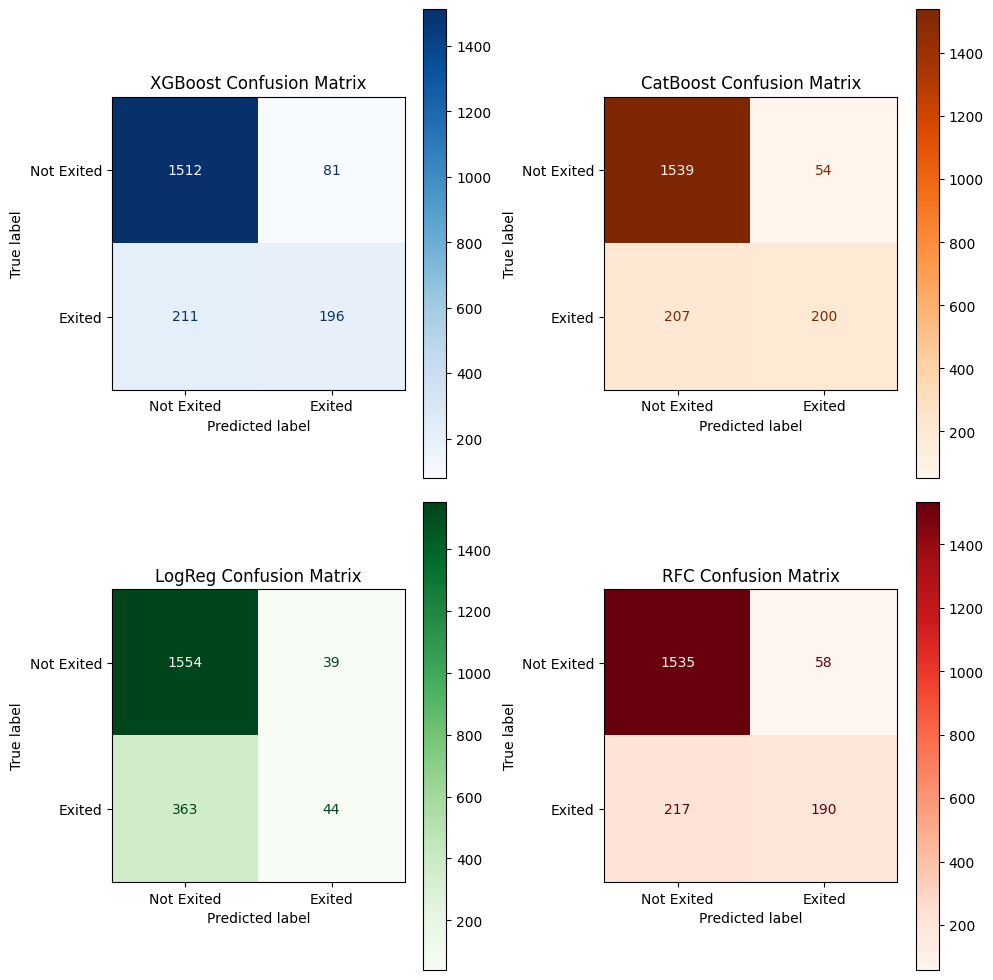

XGB accuracy: 85.39999999999999
Catboost accuracy: 86.95
Logreg accuracy: 79.9
RFC accuracy: 86.25


In [ ]:
xgb_pred1 = xgb1.predict(x_test)
catboost_pred1 = catboost1.predict(x_test)
logreg_pred1 = logreg1.predict(x_test)
rf_pred1 = rf1.predict(x_test)

xgb_cm1 = confusion_matrix(y_test,xgb_pred1)
catboost_cm1 = confusion_matrix(y_test,catboost_pred1)
logreg_cm1 = confusion_matrix(y_test,logreg_pred1)
rfc_cm1 = confusion_matrix(y_test,rf_pred1)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
disp1 = ConfusionMatrixDisplay(confusion_matrix=xgb_cm1, display_labels=['Not Exited', 'Exited'])
disp1.plot(ax=axes[0,0], cmap=plt.cm.Blues)
axes[0,0].set_title('XGBoost Confusion Matrix')

disp2 = ConfusionMatrixDisplay(confusion_matrix=catboost_cm1, display_labels=['Not Exited', 'Exited'])
disp2.plot(ax=axes[0,1], cmap=plt.cm.Oranges)
axes[0,1].set_title('CatBoost Confusion Matrix')

disp3 = ConfusionMatrixDisplay(confusion_matrix=logreg_cm1, display_labels=['Not Exited', 'Exited'])
disp3.plot(ax=axes[1,0], cmap=plt.cm.Greens)
axes[1,0].set_title('LogReg Confusion Matrix')

disp4 = ConfusionMatrixDisplay(confusion_matrix=rfc_cm1, display_labels=['Not Exited', 'Exited'])
disp4.plot(ax=axes[1,1], cmap=plt.cm.Reds)
axes[1,1].set_title('RFC Confusion Matrix')

plt.tight_layout()
plt.show()

xgb_acc1 = accuracy_score(y_test,xgb_pred1)
catboost_acc1 = accuracy_score(y_test,catboost_pred1)
logreg_acc1 = accuracy_score(y_test,logreg_pred1)
rf_acc1 = accuracy_score(y_test,rf_pred1)

print(f"XGB accuracy: {xgb_acc1*100}\nCatboost accuracy: {catboost_acc1*100}")
print(f"Logreg accuracy: {logreg_acc1*100}\nRFC accuracy: {rf_acc1*100}")

Можем заметить, что catboost справляется лучше всего, а logreg хуже всего, поэтому буду тюнить первые три по точности, это CatBoost,RFC,XGB

Тюнить буду с помощью optuna

In [ ]:
def optimize_xgb(trial):
    n_estimators = trial.suggest_int("n_estimators",50,500)
    learning_rate = trial.suggest_float("learning_rate",0.01,0.2)
    max_depth = trial.suggest_int("max_depth",3,10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    gamma = trial.suggest_float('gamma',0,8.0)
    reg_lambda = trial.suggest_float('reg_lambda',0,20.0)
    scale_pos_weight = trial.suggest_int('scale_pos_weight',1,10)

    catboost_opti = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric = "logloss",
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate, 
        min_child_weight=min_child_weight,
        subsample=subsample,
        gamma = gamma, 
        reg_lambda = reg_lambda,
        scale_pos_weight = scale_pos_weight,
        seed = random_seed
    )

    scores = cross_val_score(catboost_opti,x_train,y_train,cv=3,scoring="roc_auc")
    scores = scores.mean()

    return scores

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(optimize_xgb,n_trials=150)

print(study_xgb.best_params)
print(study_xgb.best_value)

[I 2025-05-03 21:11:24,134] A new study created in memory with name: no-name-75cb449f-cd2b-409d-a564-b9b0c60f17ec
[I 2025-05-03 21:11:24,365] Trial 0 finished with value: 0.8653425891463865 and parameters: {'n_estimators': 84, 'learning_rate': 0.13984055963021627, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.9946820518197086, 'gamma': 3.214016977061773, 'reg_lambda': 17.69556424139154, 'scale_pos_weight': 6}. Best is trial 0 with value: 0.8653425891463865.
[I 2025-05-03 21:11:24,651] Trial 1 finished with value: 0.8561697530739192 and parameters: {'n_estimators': 56, 'learning_rate': 0.17233433937912332, 'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.6180563387560343, 'gamma': 4.216916889344891, 'reg_lambda': 1.2567252448256694, 'scale_pos_weight': 3}. Best is trial 0 with value: 0.8653425891463865.
[I 2025-05-03 21:11:25,656] Trial 2 finished with value: 0.8639150428695676 and parameters: {'n_estimators': 352, 'learning_rate': 0.03474819779224991, 'max_depth': 4, 'min_

{'n_estimators': 437, 'learning_rate': 0.02239063683248447, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.6654250048745799, 'gamma': 1.2861407342729783, 'reg_lambda': 1.599215573738186, 'scale_pos_weight': 3}
0.8675329130440783


In [30]:
def optimize_catboost(trial):
    iterations = trial.suggest_int("iterations", 50, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)
    depth = trial.suggest_int("depth", 3, 10)
    l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1, 10)
    border_count = trial.suggest_int("border_count", 32, 128)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)

    model = CatBoostClassifier(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        border_count=border_count,
        subsample=subsample,
        random_seed=random_seed,
        verbose=0
    )

    scores = cross_val_score(model, x_train, y_train, cv=3, scoring="roc_auc")
    scores = scores.mean()

    return scores

study_catboost = optuna.create_study(direction="maximize")
study_catboost.optimize(optimize_catboost, n_trials=150)

print(study_catboost.best_params)
print(study_catboost.best_value)

[I 2025-05-03 21:14:14,092] A new study created in memory with name: no-name-6498b3aa-5ef4-4182-9f9c-deecb9183093
[I 2025-05-03 21:14:17,436] Trial 0 finished with value: 0.8599713954486958 and parameters: {'iterations': 309, 'learning_rate': 0.05592510756250602, 'depth': 8, 'l2_leaf_reg': 9.200342511979079, 'border_count': 38, 'subsample': 0.7682146397208914}. Best is trial 0 with value: 0.8599713954486958.
[I 2025-05-03 21:14:18,666] Trial 1 finished with value: 0.8650090667792854 and parameters: {'iterations': 245, 'learning_rate': 0.12181423039029517, 'depth': 4, 'l2_leaf_reg': 2.2976182058421926, 'border_count': 83, 'subsample': 0.8092436109661341}. Best is trial 1 with value: 0.8650090667792854.
[I 2025-05-03 21:14:23,666] Trial 2 finished with value: 0.864996433540307 and parameters: {'iterations': 317, 'learning_rate': 0.013811150706632015, 'depth': 9, 'l2_leaf_reg': 2.6100302672375024, 'border_count': 116, 'subsample': 0.7464598582387225}. Best is trial 1 with value: 0.8650090

{'iterations': 462, 'learning_rate': 0.029477062666985212, 'depth': 4, 'l2_leaf_reg': 6.5997249512811855, 'border_count': 73, 'subsample': 0.7240870709260575}
0.8702929877266881


In [31]:
def optimize_rf(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=random_seed
    )
    
    scores = cross_val_score(model, x_train, y_train, cv=3, scoring="roc_auc")
    scores = scores.mean()

    return scores

study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(optimize_rf, n_trials=150)

print(study_rf.best_params)
print(study_rf.best_value)

[I 2025-05-03 21:20:45,116] A new study created in memory with name: no-name-76e3f30c-7a5e-4f19-94c9-f0671f62813d
[I 2025-05-03 21:20:47,559] Trial 0 finished with value: 0.8466876328557119 and parameters: {'n_estimators': 297, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 14, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.8466876328557119.
[I 2025-05-03 21:20:50,865] Trial 1 finished with value: 0.8612507395922347 and parameters: {'n_estimators': 206, 'max_depth': 14, 'min_samples_split': 13, 'min_samples_leaf': 17, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.8612507395922347.
[I 2025-05-03 21:21:00,776] Trial 2 finished with value: 0.8611377506682709 and parameters: {'n_estimators': 497, 'max_depth': 28, 'min_samples_split': 11, 'min_samples_leaf': 18, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.8612507395922347.
[I 2025-05-03 21:21:04,969] Trial 3 finished with value: 0.860978764021

{'n_estimators': 499, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': True}
0.8626573993229926


In [32]:
#что в итоге
print(f"""
Score XGB: {study_xgb.best_value}
Parametrs XGB: {study_xgb.best_params}
---
Score CatBoost: {study_catboost.best_value}
Parametrs CatBoost: {study_catboost.best_params}
---
Score RF: {study_rf.best_value}
Parametrs RF: {study_rf.best_params}
""")


Score XGB: 0.8675329130440783
Parametrs XGB: {'n_estimators': 437, 'learning_rate': 0.02239063683248447, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.6654250048745799, 'gamma': 1.2861407342729783, 'reg_lambda': 1.599215573738186, 'scale_pos_weight': 3}
---
Score CatBoost: 0.8702929877266881
Parametrs CatBoost: {'iterations': 462, 'learning_rate': 0.029477062666985212, 'depth': 4, 'l2_leaf_reg': 6.5997249512811855, 'border_count': 73, 'subsample': 0.7240870709260575}
---
Score RF: 0.8626573993229926
Parametrs RF: {'n_estimators': 499, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': True}



In [33]:
#оценим их метрики
xgb_best = xgb.XGBClassifier(**study_xgb.best_params)
catboost_best = CatBoostClassifier(**study_catboost.best_params)
rf_best = RandomForestClassifier(**study_rf.best_params)

In [34]:
xgb_best.fit(x_train,y_train)
catboost_best.fit(x_train,y_train)
rf_best.fit(x_train,y_train)

0:	learn: 0.6696543	total: 2ms	remaining: 924ms
1:	learn: 0.6519625	total: 3.56ms	remaining: 818ms
2:	learn: 0.6333881	total: 6.33ms	remaining: 968ms
3:	learn: 0.6161167	total: 8.26ms	remaining: 946ms
4:	learn: 0.5985236	total: 10.6ms	remaining: 973ms
5:	learn: 0.5822255	total: 12.8ms	remaining: 975ms
6:	learn: 0.5671360	total: 16.7ms	remaining: 1.08s
7:	learn: 0.5558279	total: 19.1ms	remaining: 1.08s
8:	learn: 0.5464917	total: 21.2ms	remaining: 1.07s
9:	learn: 0.5347231	total: 22.9ms	remaining: 1.03s
10:	learn: 0.5235720	total: 24.8ms	remaining: 1.02s
11:	learn: 0.5129558	total: 27ms	remaining: 1.01s
12:	learn: 0.5030626	total: 29.5ms	remaining: 1.02s
13:	learn: 0.4955675	total: 31.4ms	remaining: 1s
14:	learn: 0.4867802	total: 33.4ms	remaining: 996ms
15:	learn: 0.4786192	total: 35.1ms	remaining: 979ms
16:	learn: 0.4717748	total: 36.6ms	remaining: 957ms
17:	learn: 0.4661549	total: 38.3ms	remaining: 946ms
18:	learn: 0.4600366	total: 39.9ms	remaining: 930ms
19:	learn: 0.4549107	total: 41

RandomForestClassifier(max_depth=20, min_samples_leaf=8, min_samples_split=8,
                       n_estimators=499)

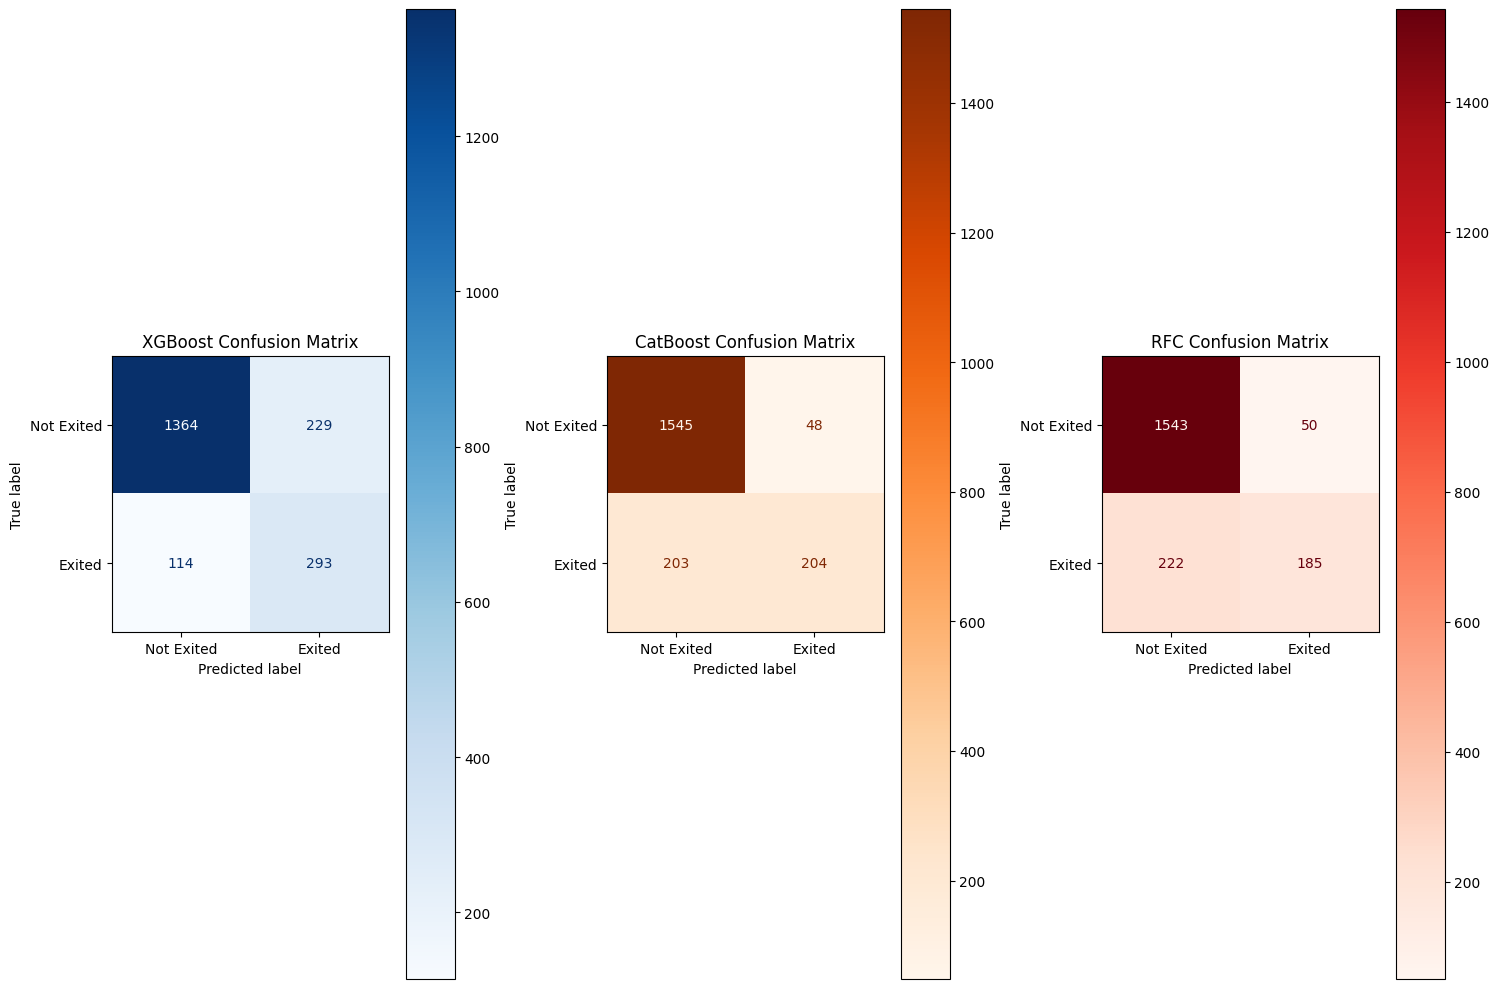

XGB accuracy: 82.85
Catboost accuracy: 87.45
RFC accuracy: 86.4
---
Precision:
 XGB: 0.5613026819923371
CatBoost: 0.8095238095238095
 RF: 0.7872340425531915
---
Recall:
 XGB: 0.7199017199017199
CatBoost: 0.5012285012285013
 RF: 0.45454545454545453
---
F1:
 XGB: 0.6307857911733046
CatBoost: 0.6191198786039454
 RF: 0.5763239875389408
---
roc_auc:
 XGB: 0.7880738982433898
CatBoost: 0.7355483372432525
 RF: 0.711579067511271


In [49]:
xgb_best_pred = xgb_best.predict(x_test)
catboost_best_pred = catboost_best.predict(x_test)
rf_best_pred = rf_best.predict(x_test)

xgb_best_cm = confusion_matrix(y_test,xgb_best_pred)
catboost_best_cm = confusion_matrix(y_test,catboost_best_pred)
rf_best_cm = confusion_matrix(y_test,rf_best_pred)

fig, axes = plt.subplots(1, 3, figsize=(15, 10))
disp1 = ConfusionMatrixDisplay(confusion_matrix=xgb_best_cm, display_labels=['Not Exited', 'Exited'])
disp1.plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title('XGBoost Confusion Matrix')

disp2 = ConfusionMatrixDisplay(confusion_matrix=catboost_best_cm, display_labels=['Not Exited', 'Exited'])
disp2.plot(ax=axes[1], cmap=plt.cm.Oranges)
axes[1].set_title('CatBoost Confusion Matrix')

disp3 = ConfusionMatrixDisplay(confusion_matrix=rf_best_cm, display_labels=['Not Exited', 'Exited'])
disp3.plot(ax=axes[2], cmap=plt.cm.Reds)
axes[2].set_title('RFC Confusion Matrix')

plt.tight_layout()
plt.show()

xgb_best_acc = accuracy_score(y_test,xgb_best_pred)
catboost_best_acc = accuracy_score(y_test,catboost_best_pred)
rf_best_acc = accuracy_score(y_test,rf_best_pred)

xgb_prescision = precision_score(y_test,xgb_best_pred)
catboost_precision = precision_score(y_test,catboost_best_pred)
rf_precision = precision_score(y_test,rf_best_pred)

xgb_recall = recall_score(y_test,xgb_best_pred)
catboost_recall = recall_score(y_test,catboost_best_pred)
rf_recall = recall_score(y_test,rf_best_pred)

xgb_f1 = f1_score(y_test,xgb_best_pred)
catboost_f1 = f1_score(y_test,catboost_best_pred)
rf_f1 = f1_score(y_test,rf_best_pred)

xgb_roc = roc_auc_score(y_test,xgb_best_pred)
catboost_roc = roc_auc_score(y_test,catboost_best_pred)
rf_roc = roc_auc_score(y_test,rf_best_pred)

print(f"XGB accuracy: {xgb_best_acc*100}\nCatboost accuracy: {catboost_best_acc*100}\nRFC accuracy: {rf_best_acc*100}")
print("---")
print(f"Precision:\n XGB: {xgb_prescision}\nCatBoost: {catboost_precision}\n RF: {rf_precision}")
print("---")
print(f"Recall:\n XGB: {xgb_recall}\nCatBoost: {catboost_recall}\n RF: {rf_recall}")
print("---")
print(f"F1:\n XGB: {xgb_f1}\nCatBoost: {catboost_f1}\n RF: {rf_f1}")
print("---")
print(f"roc_auc:\n XGB: {xgb_roc}\nCatBoost: {catboost_roc}\n RF: {rf_roc}")

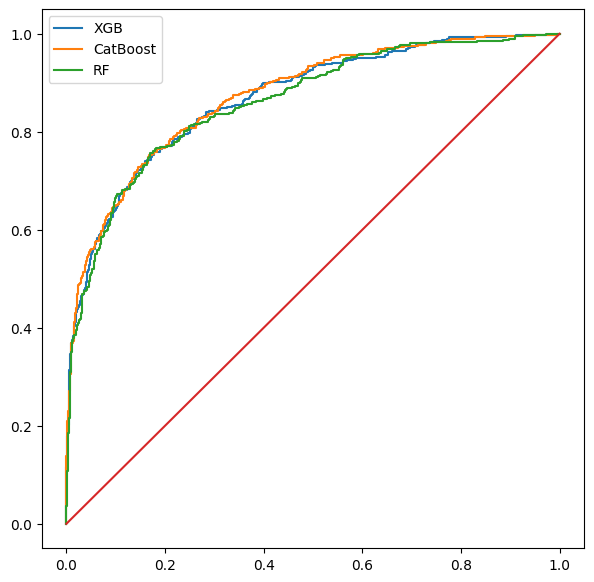

In [36]:
plt.figure(figsize=(7,7))

for name,model in [("XGB",xgb_best),("CatBoost",catboost_best),("RF",rf_best)]:
    pred_proba = model.predict_proba(x_test)[:,1]
    fpr,tpr,_ = roc_curve(y_test,pred_proba)
    auc_score = roc_auc_score(y_test,pred_proba)

    plt.plot(fpr,tpr,label = f"{name}")

plt.plot([0,1],[0,1])
plt.legend()
plt.show()

### Можно сделать вывод -> Catboost показывает себя лучше других моделей, поэтому будем показывать интерпретацию этой модели

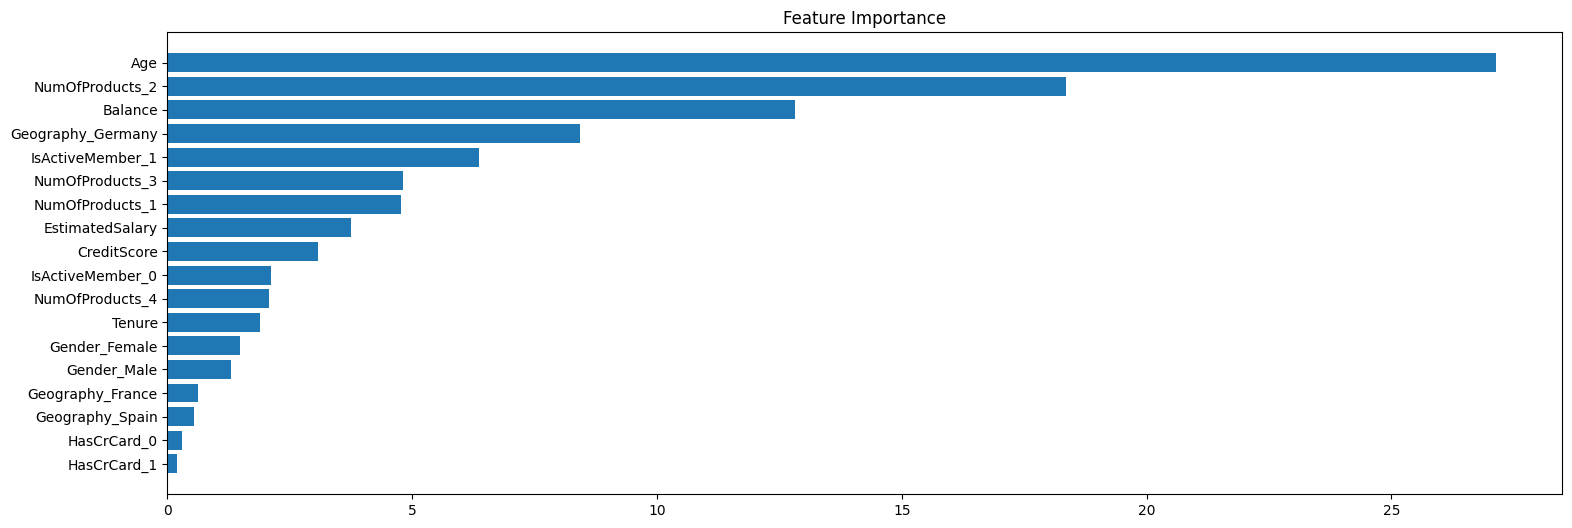

In [37]:
importance = catboost_best.feature_importances_
indices = importance.argsort()

plt.figure(figsize=(18, 6))
plt.barh(range(len(indices)), importance[indices])
plt.yticks(range(len(indices)), x_test.columns[indices])
plt.title('Feature Importance')
plt.show()

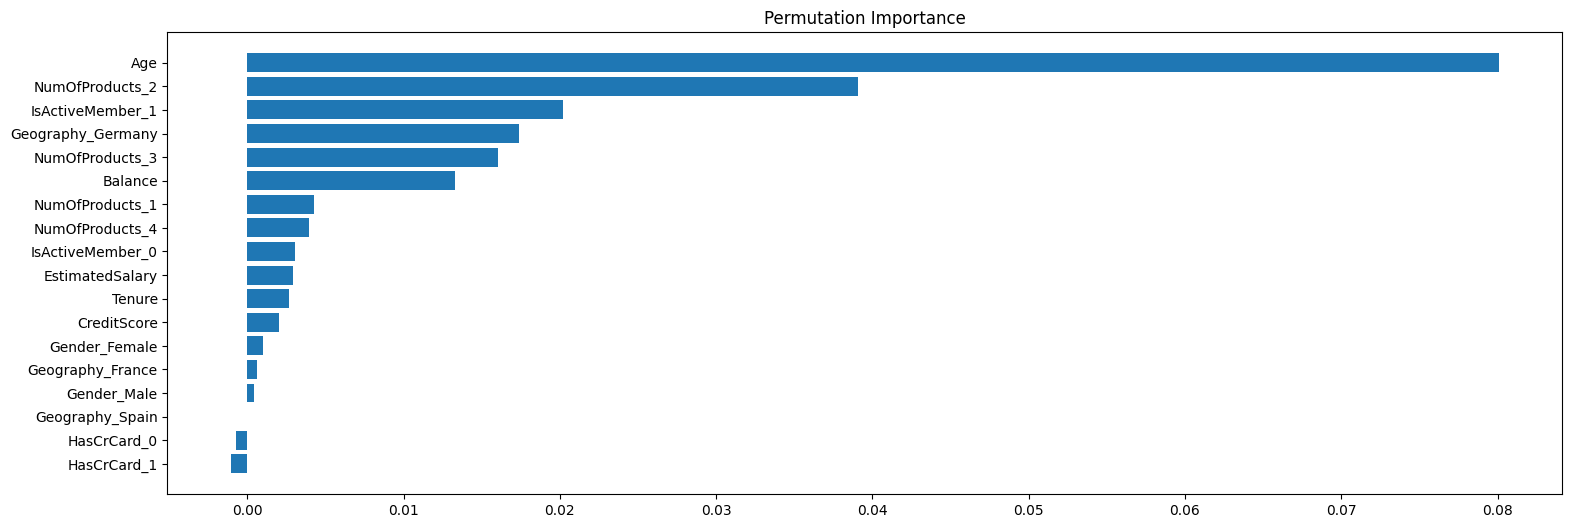

In [ ]:
perm_importance = permutation_importance(catboost_best, x_test, y_test, n_repeats=10, random_state=random_seed)
indices = perm_importance.importances_mean.argsort()

plt.figure(figsize=(18, 6))
plt.barh(range(len(indices)), perm_importance.importances_mean[indices])
plt.yticks(range(len(indices)), x_test.columns[indices])
plt.title('Permutation Importance')
plt.show()

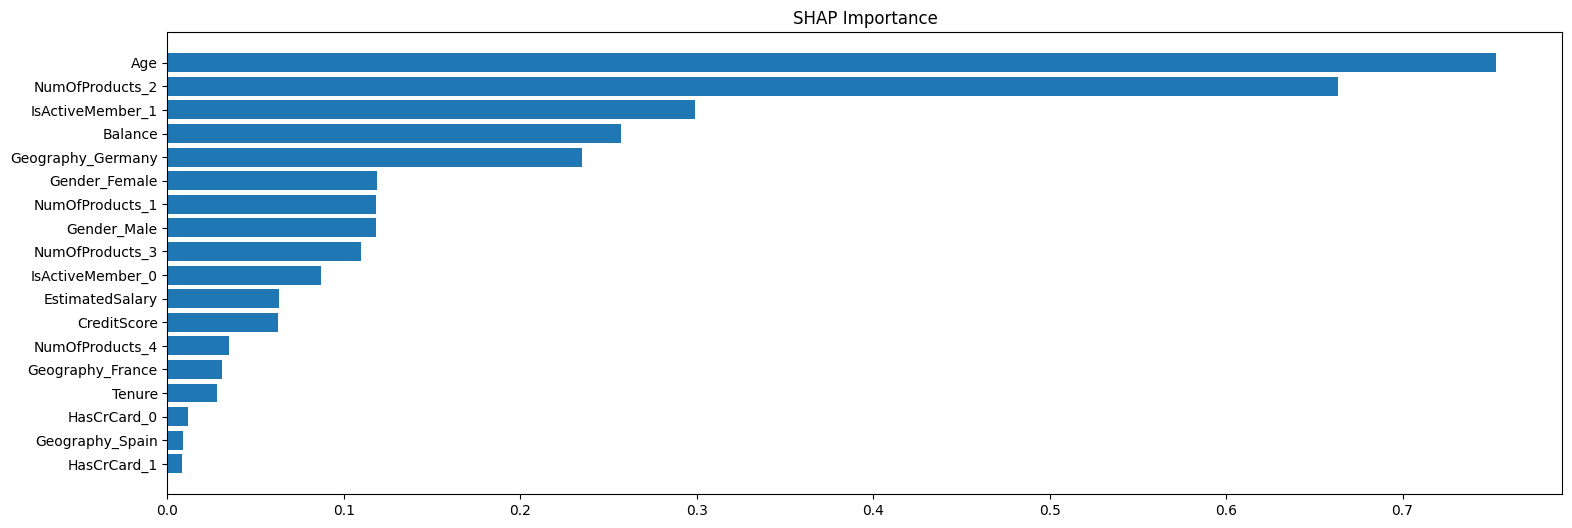

In [39]:
explainer = shap.Explainer(catboost_best)
shap_values = explainer(x_test)
shap_importance = shap_values.abs.mean(0).values
indices = shap_importance.argsort()

plt.figure(figsize=(18, 6))
plt.barh(range(len(indices)), shap_importance[indices])
plt.yticks(range(len(indices)), x_test.columns[indices])
plt.title('SHAP Importance')
plt.show()

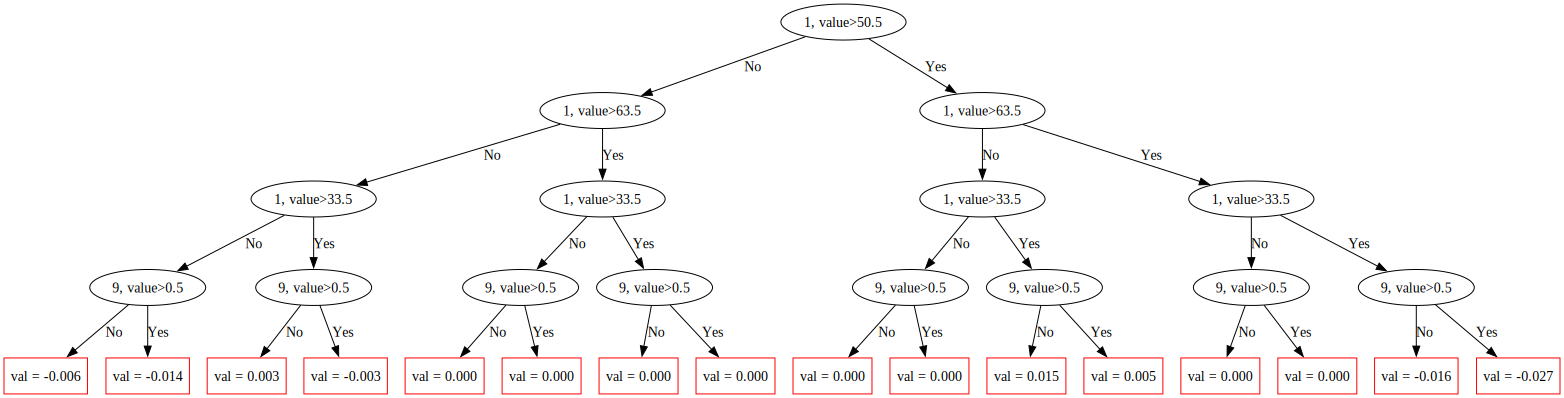

In [48]:
catboost_best.plot_tree(tree_idx=100)